In [1]:
#HMM project
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')


In [6]:
!pip install --upgrade pip
!pip install sklearn_crfsuite

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (18.1)
    100% |████████████████████████████████| 51kB 7.9MB/s ta 0:00:011
    100% |████████████████████████████████| 757kB 34.0MB/s eta 0:00:01
    100% |████████████████████████████████| 51kB 35.1MB/s ta 0:00:01
  Running setup.py bdist_wheel for tabulate ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/2a/85/33/2f6da85d5f10614cbe5a625eab3b3aebfdf43e7b857f25f829
Successfully built tabulate


In [10]:
from itertools import chain
import nltk
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import sklearn
#import pycrfsuite

import scipy.stats

from sklearn.metrics import make_scorer
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

nltk.download('conll2002')
print(sklearn.__version__)

[nltk_data] Downloading package conll2002 to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/conll2002.zip.
0.19.1


In [11]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [22]:
%%time
train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
test_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))

X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]


CPU times: user 2.44 s, sys: 173 ms, total: 2.61 s
Wall time: 2.61 s


In [21]:
print(train_sents[0])

print(sent2features(train_sents[0]))
print(sent2labels(train_sents[0]))

[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]
[{'bias': 1.0, 'word.lower()': 'melbourne', 'word[-3:]': 'rne', 'word[-2:]': 'ne', 'word.isupper()': False, 'word.istitle()': True, 'word.isdigit()': False, 'postag': 'NP', 'postag[:2]': 'NP', 'BOS': True, '+1:word.lower()': '(', '+1:word.istitle()': False, '+1:word.isupper()': False, '+1:postag': 'Fpa', '+1:postag[:2]': 'Fp'}, {'bias': 1.0, 'word.lower()': '(', 'word[-3:]': '(', 'word[-2:]': '(', 'word.isupper()': False, 'word.istitle()': False, 'word.isdigit()': False, 'postag': 'Fpa', 'postag[:2]': 'Fp', '-1:word.lower()': 'melbourne', '-1:word.istitle()': True, '-1:word.isupper()': False, '-1:postag': 'NP', '-1:postag[:2]': 'NP', '+1:word.lower()': 'australia', '+1:word.istitle()': True, '+1:word.isupper()': False, '+1:postag': 'NP', '+1:postag[:2]': 

In [19]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CPU times: user 34.1 s, sys: 15.2 ms, total: 34.1 s
Wall time: 34.1 s


In [20]:
labels = list(crf.classes_)
labels.remove('O')
labels

['B-LOC', 'B-ORG', 'B-PER', 'I-PER', 'B-MISC', 'I-ORG', 'I-LOC', 'I-MISC']

In [25]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)

0.7964686316443963

In [26]:
# group B and I results
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

             precision    recall  f1-score   support

      B-LOC      0.810     0.784     0.797      1084
      I-LOC      0.690     0.637     0.662       325
     B-MISC      0.731     0.569     0.640       339
     I-MISC      0.699     0.589     0.639       557
      B-ORG      0.807     0.832     0.820      1400
      I-ORG      0.852     0.786     0.818      1104
      B-PER      0.850     0.884     0.867       735
      I-PER      0.893     0.943     0.917       634

avg / total      0.809     0.787     0.796      6178



In [31]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  6.9min finished


CPU times: user 3min 11s, sys: 11.1 s, total: 3min 22s
Wall time: 7min 28s


In [32]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.09033636301693221, 'c2': 0.026187969440282923}
best CV score: 0.7491798180722624
model size: 1.40M


Dark blue => 0.7193, dark red => 0.7492


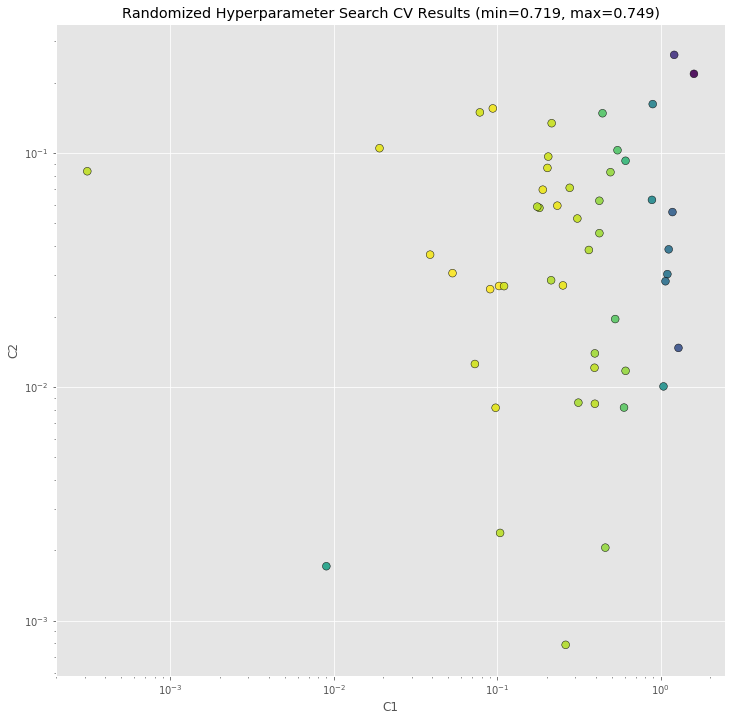

In [33]:
_x = [s.parameters['c1'] for s in rs.grid_scores_]
_y = [s.parameters['c2'] for s in rs.grid_scores_]
_c = [s.mean_validation_score for s in rs.grid_scores_]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [34]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

             precision    recall  f1-score   support

      B-LOC      0.806     0.784     0.795      1084
      I-LOC      0.694     0.655     0.674       325
     B-MISC      0.703     0.558     0.622       339
     I-MISC      0.661     0.583     0.620       557
      B-ORG      0.807     0.834     0.820      1400
      I-ORG      0.855     0.777     0.814      1104
      B-PER      0.852     0.880     0.866       735
      I-PER      0.903     0.943     0.923       634

avg / total      0.806     0.785     0.794      6178



In [35]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
B-ORG  -> I-ORG   7.625919
I-ORG  -> I-ORG   7.240342
B-MISC -> I-MISC  7.018377
I-MISC -> I-MISC  6.915597
B-PER  -> I-PER   6.810424
B-LOC  -> I-LOC   5.739742
I-PER  -> I-PER   5.186305
I-LOC  -> I-LOC   4.905902
O      -> O       4.092140
O      -> B-ORG   2.821258
O      -> B-PER   2.663075
O      -> B-LOC   1.933318
O      -> B-MISC  1.835973
B-ORG  -> O       0.550792
B-ORG  -> B-LOC   0.264166
B-LOC  -> B-LOC   0.256089
I-PER  -> B-LOC   0.175596
B-MISC -> B-ORG   0.084885
B-MISC -> O       -0.059946
B-LOC  -> O       -0.134214

Top unlikely transitions:
B-ORG  -> B-ORG   -2.660421
I-ORG  -> I-PER   -2.739899
I-LOC  -> B-MISC  -2.835019
B-ORG  -> I-LOC   -2.846616
I-MISC -> B-LOC   -2.876003
I-MISC -> I-ORG   -2.901837
I-PER  -> I-LOC   -3.016175
B-PER  -> B-MISC  -3.082400
B-ORG  -> B-MISC  -3.114552
I-PER  -> B-ORG   -3.330954
I-ORG  -> B-MISC  -3.432078
I-ORG  -> I-LOC   -3.538604
B-PER  -> B-PER   -3.580786
I-PER  -> B-MISC  -3.639347
I-MISC -> I-LOC

In [7]:
train_sents[0]

[('Melbourne', 'NP', 'B-LOC'),
 ('(', 'Fpa', 'O'),
 ('Australia', 'NP', 'B-LOC'),
 (')', 'Fpt', 'O'),
 (',', 'Fc', 'O'),
 ('25', 'Z', 'O'),
 ('may', 'NC', 'O'),
 ('(', 'Fpa', 'O'),
 ('EFE', 'NC', 'B-ORG'),
 (')', 'Fpt', 'O'),
 ('.', 'Fp', 'O')]

In [30]:
#Mine
text = nltk.word_tokenize('the new')
print(nltk.pos_tag(text))


[('the', 'DT'), ('new', 'JJ')]


In [31]:
len(train_sents)

8323